### imports & loading the data

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from scipy.stats import ttest_rel

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

In [11]:
df = pd.read_csv('/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/intfloat/e5-base-v2/explanation_deepseek_1_bm25PostFilter/augmented_retrieval_analysis.csv')

In [12]:
df.columns

Index(['query_id', 'query', 'retrieved_doc_id', 'retrieved_doc',
       'retrieved_code', 'retrieved_explanation', 'score',
       'ground_truth_relevance'],
      dtype='object')

In [13]:
len(df) # 500 queries and top 1000 (k=1000) so we have 500,000

500000

In [14]:
df.describe()

,score,ground_truth_relevance
count,500000.000000,500000.000000
mean,0.606296,0.000984
std,0.087007,0.031353
min,0.378316,0.000000
25%,0.547253,0.000000
50%,0.601132,0.000000
75%,0.657227,0.000000
max,1.000000,1.000000


In [15]:
ground_truth_map = df[df["ground_truth_relevance"] == 1].set_index("query")["retrieved_explanation"].to_dict()

df["ground_truth_explanation"] = df["query"].map(ground_truth_map).fillna("")

# if for a query ground truth is not in top 1000 then this col will be marked as ""

In [16]:
df.isna().sum()

query_id                    0
query                       0
retrieved_doc_id            0
retrieved_doc               0
retrieved_code              0
retrieved_explanation       0
score                       0
ground_truth_relevance      0
ground_truth_explanation    0
dtype: int64

### How many docs before the first ground truth appears?

In [17]:
ground_truth_ranks = []

for query_id, group in df.groupby("query_id"):
    group = group.reset_index()  
    first_index = group.index[0] 
    
    # Find ground truth occurrences
    relevant_docs = group[group["ground_truth_relevance"] == 1]
    
    if not relevant_docs.empty:
        first_gt_rank = relevant_docs.index.min() - first_index + 1  # Rank calculation
        total_relevant = len(relevant_docs)
    else:
        first_gt_rank = 1001
        total_relevant = 0

    ground_truth_ranks.append({
        "Query ID": query_id,
        "First GT Rank": first_gt_rank,
        "Total GT": total_relevant
    })
    
result_df = pd.DataFrame(ground_truth_ranks)
result_df.head()

,Query ID,First GT Rank,Total GT
0,q20105,99,1
1,q20106,99,1
2,q20107,7,1
3,q20108,18,1
4,q20109,1,1


In [18]:
valid_ranks = result_df[result_df["First GT Rank"] != 1001]["First GT Rank"]

average_first_gt_rank = valid_ranks.mean()

print(f"Average First GT Rank: {average_first_gt_rank:.4f}")

Average First GT Rank: 34.5915


In [19]:
result_df['First GT Rank'].describe()

count     500.000000
mean       50.054000
std       146.180315
min         1.000000
25%         2.000000
50%         6.000000
75%        25.000000
max      1001.000000
Name: First GT Rank, dtype: float64

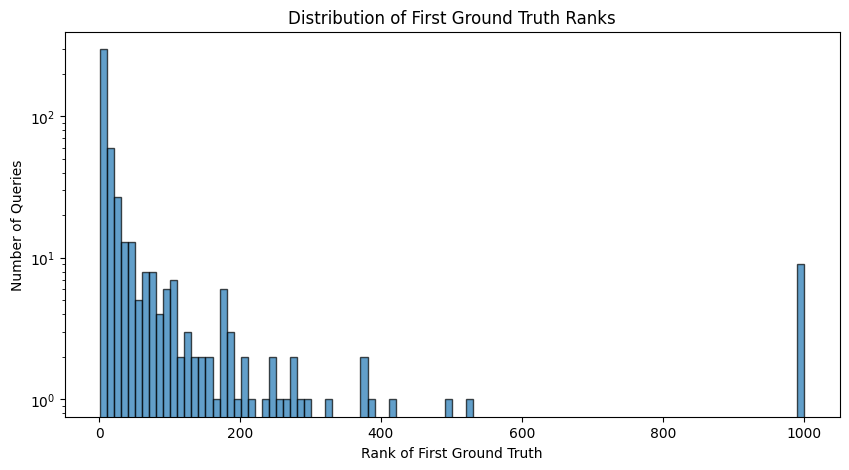

In [20]:
plt.figure(figsize=(10, 5))
plt.hist(result_df['First GT Rank'], bins=np.arange(1, 1002, 10), edgecolor="black", alpha=0.7)
plt.xlabel("Rank of First Ground Truth")
plt.ylabel("Number of Queries")
plt.title("Distribution of First Ground Truth Ranks")
plt.yscale("log")  
plt.show()


In [21]:
invalid_ranks = result_df[result_df["First GT Rank"] == 1001]["First GT Rank"]
print(f"Queries for which GT not retrieved: {len(invalid_ranks)} out of {len(result_df)} ({len(invalid_ranks)/len(result_df) * 100})%")

Queries for which GT not retrieved: 8 out of 500 (1.6)%


In [22]:
first_gt_ranks = result_df['First GT Rank'].tolist()

mrr = np.mean([1/rank for rank in first_gt_ranks if rank <= 1000])
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")


Mean Reciprocal Rank (MRR): 0.3550


### Finding patterns in query results

In [23]:
correct_retrievals = df[df["ground_truth_relevance"] == 1]
incorrect_retrievals = df[df["ground_truth_relevance"] == 0]

/tmp/ipykernel_981671/4025150044.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
/tmp/ipykernel_981671/4025150044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)


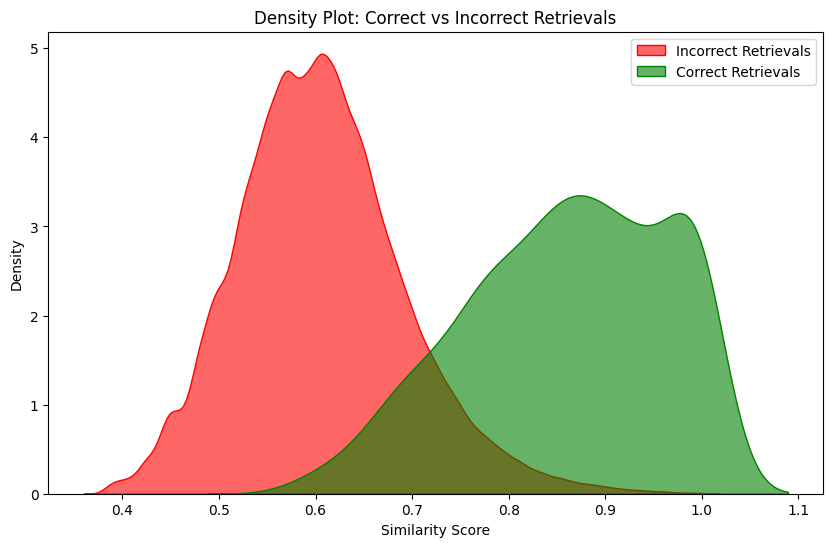

In [24]:
plt.figure(figsize=(10, 6))
sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)

plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.title('Density Plot: Correct vs Incorrect Retrievals')
plt.legend()
plt.show()


In [25]:
df['top_retrieved_score'] = df.groupby('query')['score'].transform('max')
df['score_difference'] = df['top_retrieved_score'] - df['score']

In [26]:
df['score_difference'].describe()

count    500000.000000
mean          0.362137
std           0.096511
min           0.000000
25%           0.299989
50%           0.365327
75%           0.428262
max           0.621684
Name: score_difference, dtype: float64

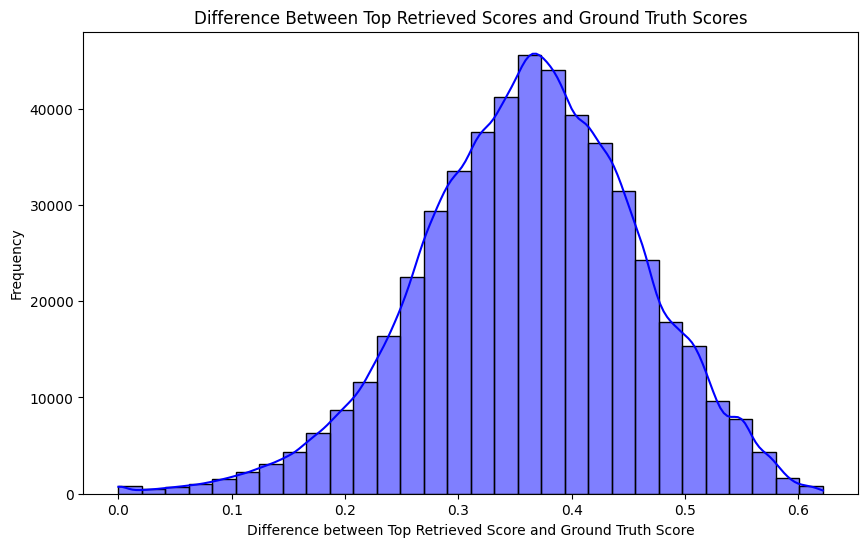

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(df['score_difference'], bins=30, kde=True, color='b')
plt.xlabel('Difference between Top Retrieved Score and Ground Truth Score')
plt.ylabel('Frequency')
plt.title('Difference Between Top Retrieved Scores and Ground Truth Scores')
plt.show()

### Analyzing Term Frequencies & BM25 Impact

In [28]:
def token_overlap(query, explanation):
    query_tokens = set(word for word in query.lower().split() if word not in stop_words)
    explanation_tokens = set(word for word in explanation.lower().split() if word not in stop_words)
    return len(query_tokens.intersection(explanation_tokens))

In [29]:
df["retrieved_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["retrieved_explanation"]), axis=1)

df["ground_truth_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["ground_truth_explanation"]) , axis=1)

In [30]:
df

,query_id,query,retrieved_doc_id,retrieved_doc,retrieved_code,retrieved_explanation,score,ground_truth_relevance,ground_truth_explanation,top_retrieved_score,score_difference,retrieved_overlap,ground_truth_overlap
0,q20105,sort by a token in string python,d20095,test the number of characters in python list,"def token_list_len(tokenlist):\n """"""\n R...",The doc string explains that the function toke...,0.971443,0,The doc and code both clean a string by splitt...,0.971443,0.000000,3,1
1,q20105,sort by a token in string python,d20330,python read tokens from line,def get_tokens(line: str) -> Iterator[str]:\n ...,The doc and code explain a function called get...,0.966721,0,The doc and code both clean a string by splitt...,0.971443,0.004721,2,1
2,q20105,sort by a token in string python,d1629,loop through tokens in a string python,"def tokenize(string):\n """"""Match and yield ...",The docstring and code snippet are explaining ...,0.950767,0,The doc and code both clean a string by splitt...,0.971443,0.020676,2,1
3,q20105,sort by a token in string python,d13945,invalid token python for an array,def append_position_to_token_list(token_list):...,The docstring and code snippet indicate that t...,0.938883,0,The doc and code both clean a string by splitt...,0.971443,0.032559,1,1
4,q20105,sort by a token in string python,d18360,how to parse a line into tokens in python,def get_tokens(line: str) -> Iterator[str]:\n ...,The doc string and code explain a function tha...,0.938579,0,The doc and code both clean a string by splitt...,0.971443,0.032864,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,q20604,how do i unzip file in python,d7127,how do you create an hash of value in python,"def get_point_hash(self, point):\n """"""\...",The doc string explains how to create a geohas...,0.528942,0,The code snippet defines a function `_unzip_ha...,0.925811,0.396869,1,1
499996,q20604,how do i unzip file in python,d4970,python iter not next,"def __next__(self):\n """"""Pop the head off t...",The doc string and code are both explaining th...,0.528939,0,The code snippet defines a function `_unzip_ha...,0.925811,0.396872,0,1
499997,q20604,how do i unzip file in python,d6807,delete contents of a text file in python open ...,"def delete(filething):\n """"""Remove tags fro...",The doc and code explain how to remove tags fr...,0.528878,0,The code snippet defines a function `_unzip_ha...,0.925811,0.396933,1,1
499998,q20604,how do i unzip file in python,d12061,python yaml multiple documents stream,"def safe_dump_all(documents, stream=None, **kw...",The doc describes a function that serializes m...,0.528790,0,The code snippet defines a function `_unzip_ha...,0.925811,0.397021,1,1


In [31]:
print(token_overlap(df['query'][0],df['retrieved_explanation'][0]))

3


In [32]:
retrieved_avg = df["retrieved_overlap"].mean()
ground_truth_avg = df["ground_truth_overlap"].mean()

print(f"Average Token Overlap - Retrieved Explanations: {retrieved_avg:.2f}")
print(f"Average Token Overlap - Ground Truth Explanations: {ground_truth_avg:.2f}")

Average Token Overlap - Retrieved Explanations: 0.80
Average Token Overlap - Ground Truth Explanations: 1.77


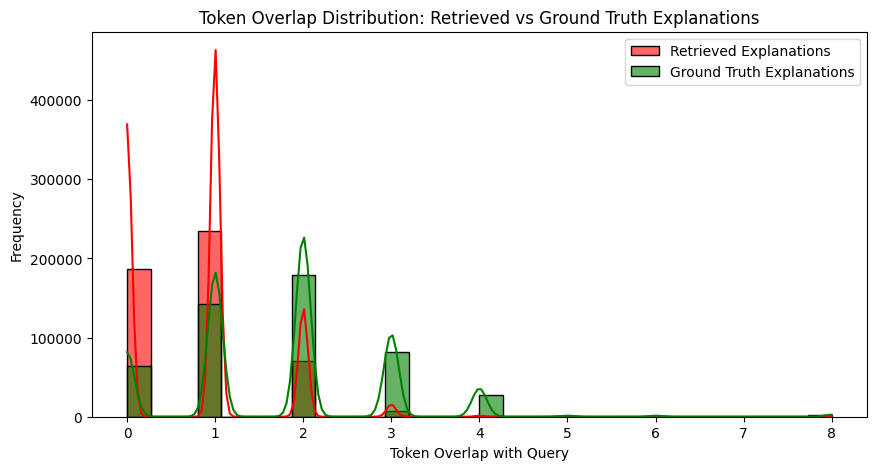

In [33]:
plt.figure(figsize=(10, 5))
sns.histplot(df["retrieved_overlap"], bins=30, color="red", label="Retrieved Explanations", alpha=0.6, kde=True)
sns.histplot(df["ground_truth_overlap"], bins=30, color="green", label="Ground Truth Explanations", alpha=0.6, kde=True)
plt.xlabel("Token Overlap with Query")
plt.ylabel("Frequency")
plt.title("Token Overlap Distribution: Retrieved vs Ground Truth Explanations")
plt.legend()
plt.show()

In [34]:
avg_query_token_size = df["query"].apply(lambda x: len([word for word in x.lower().split() if word not in stop_words])).mean()

print(f"Average Query Token Size: {avg_query_token_size:.2f}")

Average Query Token Size: 4.65


In [35]:
higher_gt_overlap = (df["ground_truth_overlap"] > df["retrieved_overlap"]).sum()
total_rows = len(df)

print(f"Ground Truth Overlap > Retrieved Overlap: {higher_gt_overlap}/{total_rows} ({(higher_gt_overlap/total_rows)*100:.2f}%)")

Ground Truth Overlap > Retrieved Overlap: 319480/500000 (63.90%)
